# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: Bastián Rubio Moya.

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Subir datasets de dígitos (train)

In [2]:
#Descargar Archivos
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt

--2023-10-22 21:17:06--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt’

1_digits_train.txt  100%[===================>] 625.59K  --.-KB/s    in 0.05s   

2023-10-22 21:17:07 (11.2 MB/s) - ‘1_digits_train.txt’ saved [640604/640604]

--2023-10-22 21:17:07--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200

## Leer dataset de dígitos

In [3]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [4]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,0,0,9,11,0,0,0,0,0,7,...,0,0,0,8,12,12,15,10,0,2
4343,0,0,6,15,2,0,0,0,0,0,...,0,0,0,7,16,16,10,1,0,6
4344,0,0,15,16,16,14,0,0,0,0,...,0,0,0,14,11,0,0,0,0,7
4345,0,0,0,1,15,11,0,0,0,0,...,0,0,0,0,1,16,10,0,0,4


In [5]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
1268,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
1269,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
1270,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


In [6]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

In [7]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

df_train

<ipython-input-7-c87e9390b53a>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-7-c87e9390b53a>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-7-c87e9390b53a>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


## Crear datasets y dataloaders para pytorch (train)

In [8]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [9]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Entrenamiento

In [10]:
def trainning(model):
  start = time.time()

  # Guardar resultados del loss y epocas que duró el entrenamiento
  loss_train = []
  loss_val = []
  epochs = []

  # Guardar el tiempo transcurrido en cada época
  time_points = []

  # Variables para el early stopping
  best_loss_val = 10000000000000
  patience = 10 #Número de epoch para esperar antes que termine el entrenamiento
  wait = 0 #Contador de espera

  # Entrenamiento de la red por n epocas
  for epoch in range(1000):

    # Guardar loss de cada batch
    loss_train_batches = []
    loss_val_batches = []

    # Entrenamiento --------------------------------------------------------------
    model.train()
    # Debemos recorrer cada batch (lote de los datos)
    for i, data in enumerate(dataloader_train, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = model(inputs)           # Predicciones
      loss = criterion(outputs, labels) # Loss de entrenamiento
      loss.backward()                   # Backpropagation
      optimizer.step()

      # Guardamos la pérdida de entrenamiento en el batch actual
      loss_train_batches.append(loss.item())

    # Guardamos el loss de entrenamiento de la época actual
    loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches


    # Predicción en conjunto de validación ---------------------------------------
    model.eval()
    with torch.no_grad():
      # Iteramos dataloader_val para evaluar el modelo en los datos de validación
      for i, data in enumerate(dataloader_val, 0):
        # Procesar batch actual
        inputs = data["features"].to(device) # Características
        labels = data["labels"].to(device)   # Clases

        outputs = model(inputs)              # Obtenemos predicciones

        # Guardamos la pérdida de validación en el batch actual
        loss = criterion(outputs, labels)
        loss_val_batches.append(loss.item())

    # Guardamos el Loss de validación de la época actual
    loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
    # Guardamos la época
    epochs.append(epoch)

    # Guardamos el tiempo transcurrido
    time_points.append(time.time() - start)

    # Imprimir la pérdida de entrenamiento/validación en la época actual
    print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))

    # Early-stopping
    if(loss_val[epoch] < best_loss_val): #Si la perdida de la epoch es menor que la mejor perdida global, la reasignamos y reiniciamos el contador
      best_loss_val = loss_val[epoch]
      wait = 0
    else: #En caso contrario se suma el contador
      wait += 1

    #print(f"wait: {wait}, best_loss_val: {best_loss_val}") <- Descomentar para ver como funciona
    #Si el contador supera (o iguala) la paciencia se activa el early-stopping
    if (wait >= patience):
      print(f"Se activo el early-stopping en la época {epoch}")
      break

  # Matriz de confusión Entrenamiento -------------------------------------------------------------------------------

  # Calcular la matriz de confusión y accuracy normalizado en el conjunto de entrenamiento
  model.eval()
  with torch.no_grad():
      # Preparar los datos de entrenamiento
      labels_train = []
      predictions_train = []

      for i, data in enumerate(dataloader_train, 0):
          inputs = data["features"].to(device)
          labels = data["labels"].to(device)

          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)

          labels_train.extend(labels.cpu().numpy())
          predictions_train.extend(predicted.cpu().numpy())

  # Calcular la matriz de confusión en el conjunto de entrenamiento
  confusion_matrix_normalized_train = confusion_matrix(labels_train, predictions_train, normalize='true')

  # Calcular el accuracy normalizado en el conjunto de entrenamiento
  accuracy_normalized_train = accuracy_score(labels_train, predictions_train)



  # Matriz de confusión Validación -------------------------------------------------------------------------------

  # Calcular la matriz de confusión y accuracy normalizado en el conjunto de validación
  model.eval()
  with torch.no_grad():
      # Preparar los datos de validación
      val_labels = []
      val_predictions = []

      for i, data in enumerate(dataloader_val, 0):
          inputs = data["features"].to(device)
          labels = data["labels"].to(device)

          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)

          val_labels.extend(labels.cpu().numpy())
          val_predictions.extend(predicted.cpu().numpy())

  end = time.time()
  print('Finished Training, total time %f seconds' % (end - start))

  # Calcular la matriz de confusión en el conjunto de validación
  confusion_matrix_normalized_val = confusion_matrix(val_labels, val_predictions, normalize='true')

  # Calcular el accuracy normalizado en el conjunto de validación
  accuracy_normalized_val = accuracy_score(val_labels, val_predictions)

  # Mostrar la matriz de confusión en el conjunto de entrenamiento con colores
  plt.figure(figsize=(8, 6))
  sns.heatmap(confusion_matrix_normalized_train, annot=True, cmap='Blues', cbar=False)
  plt.xlabel('Clase Predicha')
  plt.ylabel('Clase Verdadera')
  plt.title(f'Matriz de Confusión Normalizada en Entrenamiento (Accuracy = {accuracy_normalized_train:.2f})')
  plt.show()

  # Mostrar la matriz de confusión en el conjunto de validación con colores
  plt.figure(figsize=(8, 6))
  sns.heatmap(confusion_matrix_normalized_val, annot=True, cmap='Blues', cbar=False)
  plt.xlabel('Clase Predicha')
  plt.ylabel('Clase Verdadera')
  plt.title(f'Matriz de Confusión Normalizada en Validación (Accuracy = {accuracy_normalized_val:.2f})')
  plt.show()

  # Graficar el loss de entrenamiento y el de validación en función del tiempo
  plt.figure()
  plt.plot(time_points, loss_train, 'b',label='Training Loss')
  plt.plot(time_points, loss_val, 'r',label='Validation Loss')
  plt.xlabel('Tiempo (segundos)')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Curvas de Loss en función del tiempo')
  plt.show()


## Crear modelos

Creación de distintos modelos a comparar

Epoch: 0, train loss: 2.2595, val loss: 2.1812
Epoch: 1, train loss: 2.0827, val loss: 1.9922
Epoch: 2, train loss: 1.8908, val loss: 1.7942
Epoch: 3, train loss: 1.6825, val loss: 1.5834
Epoch: 4, train loss: 1.4784, val loss: 1.4112
Epoch: 5, train loss: 1.2900, val loss: 1.2173
Epoch: 6, train loss: 1.1280, val loss: 1.0662
Epoch: 7, train loss: 0.9942, val loss: 0.9298
Epoch: 8, train loss: 0.8904, val loss: 0.8585
Epoch: 9, train loss: 0.8076, val loss: 0.7723
Epoch: 10, train loss: 0.7395, val loss: 0.7377
Epoch: 11, train loss: 0.6786, val loss: 0.6371
Epoch: 12, train loss: 0.6246, val loss: 0.6171
Epoch: 13, train loss: 0.5769, val loss: 0.5534
Epoch: 14, train loss: 0.5291, val loss: 0.5106
Epoch: 15, train loss: 0.4857, val loss: 0.4537
Epoch: 16, train loss: 0.4415, val loss: 0.4173
Epoch: 17, train loss: 0.4015, val loss: 0.3766
Epoch: 18, train loss: 0.3657, val loss: 0.3477
Epoch: 19, train loss: 0.3359, val loss: 0.3395
Epoch: 20, train loss: 0.3100, val loss: 0.2962
Ep

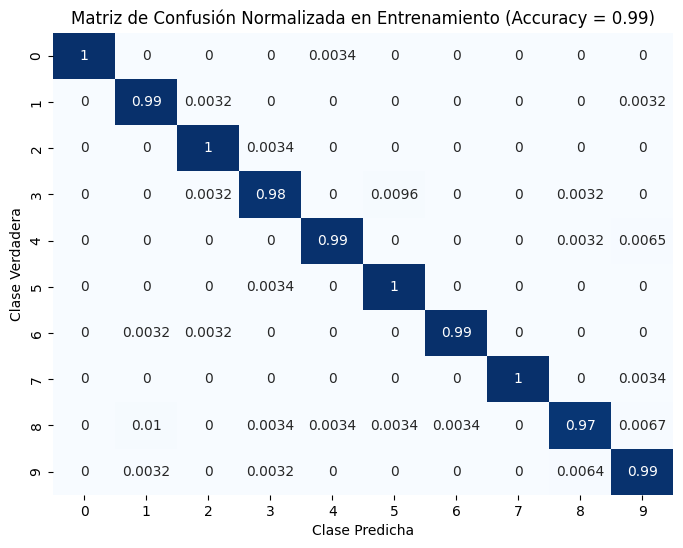

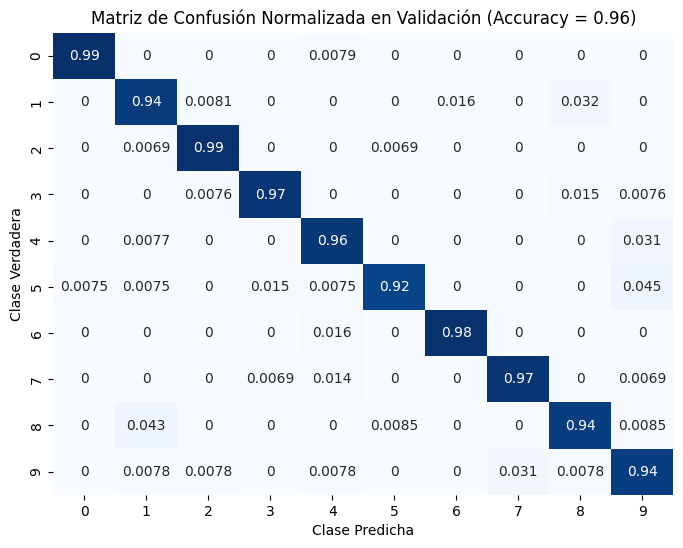

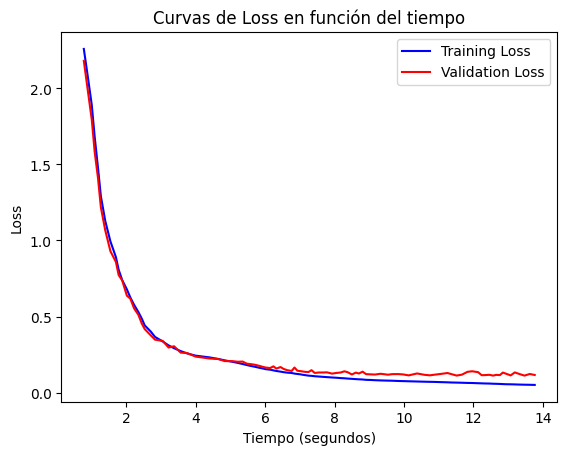

In [11]:
#Modelo 1
#10 neuronas en la capa oculta, usando función de activación ReLU
model1 = nn.Sequential(
          nn.Linear(64, 10), #Capa de entrada con 64 caracteristicas y 10 neuronas
          nn.ReLU(),         #Función de activación ReLU
          nn.Linear(10,10)   #Capa oculta con 10 neuronas y 10 de salida
        )


#Funciones de los modelos
device = torch.device('cuda')
model1 = model1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)

#Entrenar
trainning(model1)

Epoch: 0, train loss: 2.1685, val loss: 1.9689
Epoch: 1, train loss: 1.7656, val loss: 1.5347
Epoch: 2, train loss: 1.3266, val loss: 1.1008
Epoch: 3, train loss: 0.9437, val loss: 0.7926
Epoch: 4, train loss: 0.6736, val loss: 0.5660
Epoch: 5, train loss: 0.5002, val loss: 0.4276
Epoch: 6, train loss: 0.3884, val loss: 0.3636
Epoch: 7, train loss: 0.3186, val loss: 0.3103
Epoch: 8, train loss: 0.2698, val loss: 0.2666
Epoch: 9, train loss: 0.2343, val loss: 0.2235
Epoch: 10, train loss: 0.2076, val loss: 0.2100
Epoch: 11, train loss: 0.1872, val loss: 0.1912
Epoch: 12, train loss: 0.1698, val loss: 0.1696
Epoch: 13, train loss: 0.1556, val loss: 0.1549
Epoch: 14, train loss: 0.1434, val loss: 0.1456
Epoch: 15, train loss: 0.1325, val loss: 0.1448
Epoch: 16, train loss: 0.1233, val loss: 0.1370
Epoch: 17, train loss: 0.1154, val loss: 0.1226
Epoch: 18, train loss: 0.1083, val loss: 0.1260
Epoch: 19, train loss: 0.1016, val loss: 0.1164
Epoch: 20, train loss: 0.0953, val loss: 0.1125
Ep

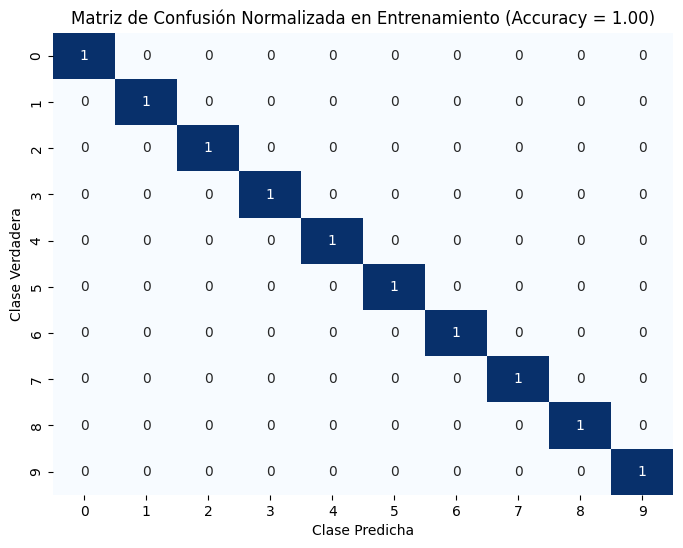

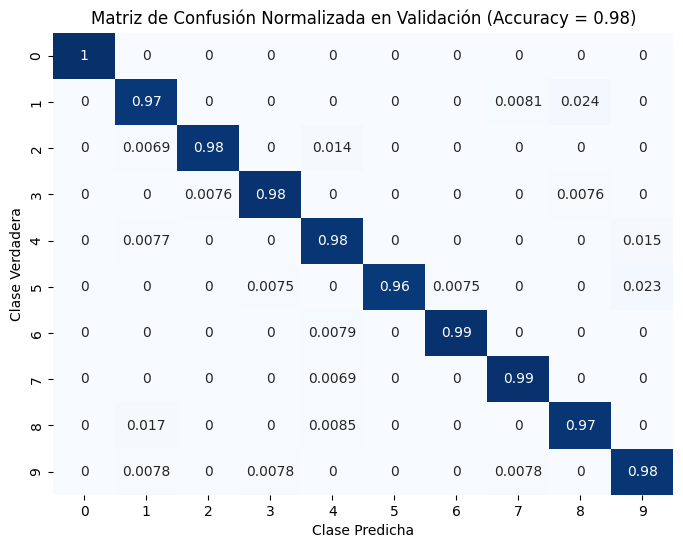

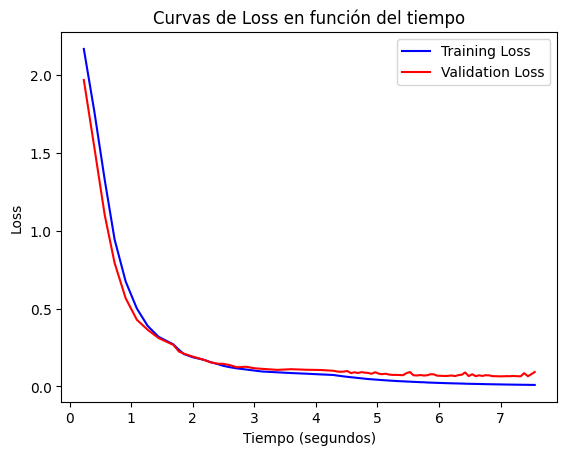

In [12]:
#Modelo 2
#40 neuronas en la capa oculta y función de activación ReLU
model2 = nn.Sequential(
          nn.Linear(64, 40), #Capa de entrada con 64 caracteristicas y 40 neuronas
          nn.ReLU(),         #Función de activación ReLU
          nn.Linear(40,10)   #Capa oculta con 40 neuronas y 10 de salida
        )

#Funciones de los modelos
device = torch.device('cuda')
model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

#Entrenar
trainning(model2)

Epoch: 0, train loss: 2.2756, val loss: 2.1325
Epoch: 1, train loss: 2.0274, val loss: 1.9213
Epoch: 2, train loss: 1.8319, val loss: 1.7615
Epoch: 3, train loss: 1.6661, val loss: 1.5914
Epoch: 4, train loss: 1.5176, val loss: 1.4350
Epoch: 5, train loss: 1.3813, val loss: 1.3138
Epoch: 6, train loss: 1.2563, val loss: 1.1954
Epoch: 7, train loss: 1.1406, val loss: 1.0852
Epoch: 8, train loss: 1.0352, val loss: 0.9779
Epoch: 9, train loss: 0.9385, val loss: 0.8755
Epoch: 10, train loss: 0.8526, val loss: 0.8099
Epoch: 11, train loss: 0.7762, val loss: 0.7548
Epoch: 12, train loss: 0.7089, val loss: 0.6774
Epoch: 13, train loss: 0.6505, val loss: 0.6181
Epoch: 14, train loss: 0.6001, val loss: 0.5882
Epoch: 15, train loss: 0.5548, val loss: 0.5415
Epoch: 16, train loss: 0.5163, val loss: 0.5009
Epoch: 17, train loss: 0.4834, val loss: 0.4666
Epoch: 18, train loss: 0.4545, val loss: 0.4497
Epoch: 19, train loss: 0.4294, val loss: 0.4191
Epoch: 20, train loss: 0.4056, val loss: 0.3969
Ep

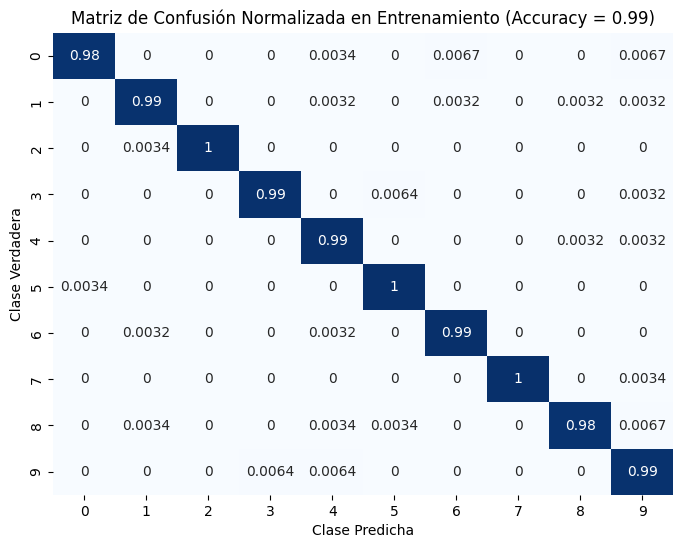

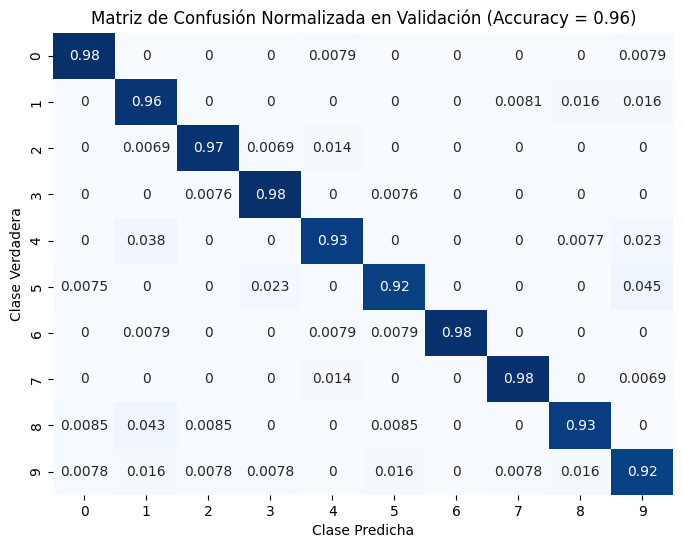

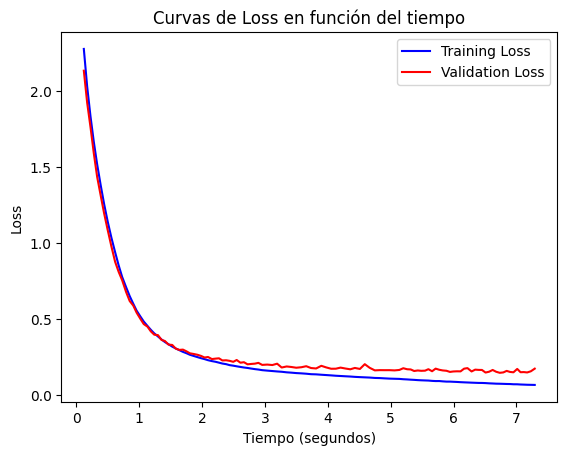

In [13]:
#Modelo 3
#10 neuronas en la capa oculta y función de activación Tanh
model3 = nn.Sequential(
          nn.Linear(64, 10), #Capa de entrada con 64 caracteristicas y 10 neuronas
          nn.Tanh(),         #Función de activación ReLU
          nn.Linear(10,10)   #Capa oculta con 10 neuronas y 10 de salida
        )

#Funciones de los modelos
device = torch.device('cuda')
model3 = model3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=1e-3)

#Entrenar
trainning(model3)

Epoch: 0, train loss: 1.9874, val loss: 1.7040
Epoch: 1, train loss: 1.4990, val loss: 1.2925
Epoch: 2, train loss: 1.1314, val loss: 0.9797
Epoch: 3, train loss: 0.8566, val loss: 0.7310
Epoch: 4, train loss: 0.6615, val loss: 0.5773
Epoch: 5, train loss: 0.5226, val loss: 0.4561
Epoch: 6, train loss: 0.4270, val loss: 0.3865
Epoch: 7, train loss: 0.3592, val loss: 0.3463
Epoch: 8, train loss: 0.3105, val loss: 0.2899
Epoch: 9, train loss: 0.2743, val loss: 0.2717
Epoch: 10, train loss: 0.2450, val loss: 0.2420
Epoch: 11, train loss: 0.2230, val loss: 0.2216
Epoch: 12, train loss: 0.2034, val loss: 0.2069
Epoch: 13, train loss: 0.1882, val loss: 0.1969
Epoch: 14, train loss: 0.1736, val loss: 0.1952
Epoch: 15, train loss: 0.1621, val loss: 0.1784
Epoch: 16, train loss: 0.1528, val loss: 0.1649
Epoch: 17, train loss: 0.1436, val loss: 0.1583
Epoch: 18, train loss: 0.1349, val loss: 0.1529
Epoch: 19, train loss: 0.1288, val loss: 0.1510
Epoch: 20, train loss: 0.1215, val loss: 0.1566
Ep

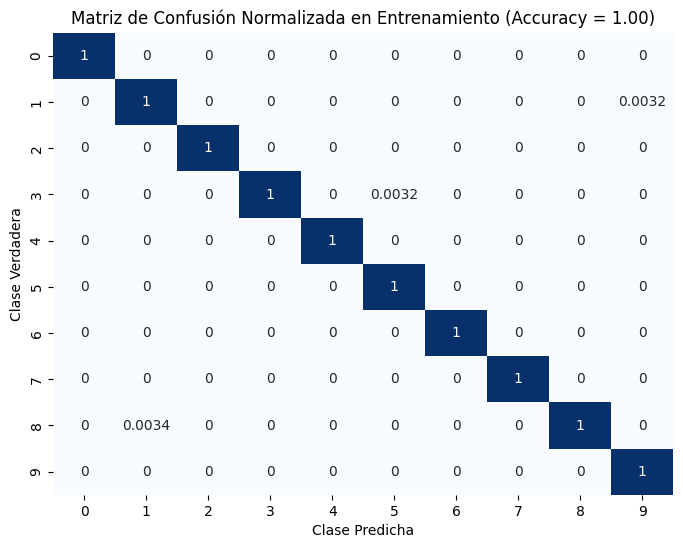

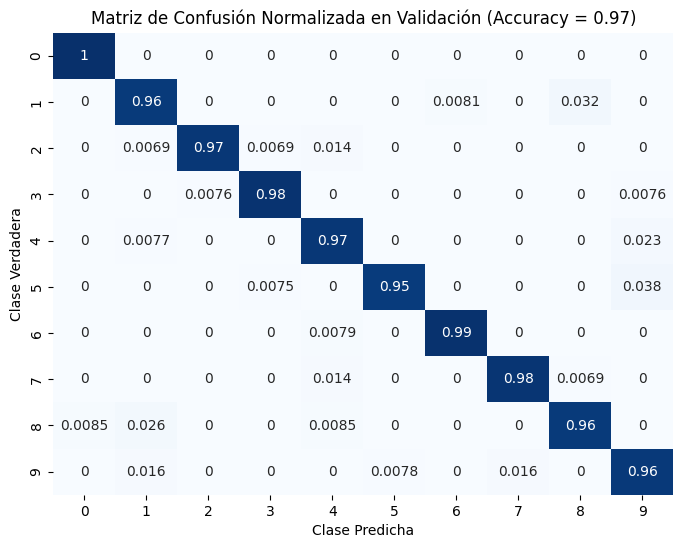

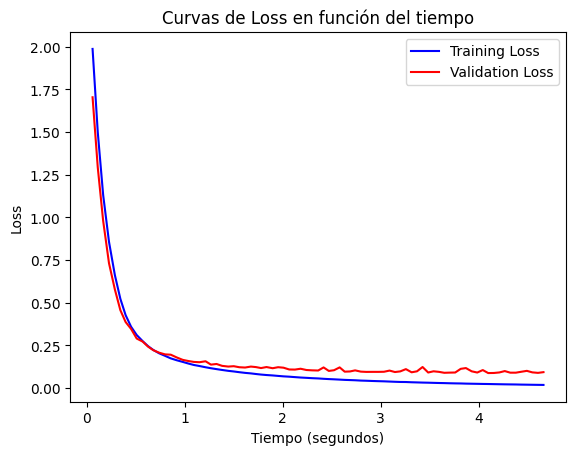

In [14]:
#Modelo 4
#40 neuronas en la capa oculta y función de activación Tanh
model4 = nn.Sequential(
          nn.Linear(64, 40), #Capa de entrada con 64 caracteristicas y 40 neuronas
          nn.Tanh(),         #Función de activación ReLU
          nn.Linear(40,10)   #Capa oculta con 40 neuronas y 10 de salida
        )
#Funciones de los modelos
device = torch.device('cuda')
model4 = model4.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=1e-3)

#Entrenar
trainning(model4)

Epoch: 0, train loss: 2.2872, val loss: 2.2449
Epoch: 1, train loss: 2.1932, val loss: 2.1364
Epoch: 2, train loss: 2.0620, val loss: 1.9787
Epoch: 3, train loss: 1.8761, val loss: 1.7753
Epoch: 4, train loss: 1.6479, val loss: 1.5289
Epoch: 5, train loss: 1.4116, val loss: 1.2869
Epoch: 6, train loss: 1.1994, val loss: 1.0998
Epoch: 7, train loss: 1.0226, val loss: 0.9342
Epoch: 8, train loss: 0.8816, val loss: 0.8080
Epoch: 9, train loss: 0.7704, val loss: 0.7217
Epoch: 10, train loss: 0.6811, val loss: 0.6368
Epoch: 11, train loss: 0.6134, val loss: 0.5953
Epoch: 12, train loss: 0.5568, val loss: 0.5251
Epoch: 13, train loss: 0.5124, val loss: 0.5125
Epoch: 14, train loss: 0.4748, val loss: 0.4649
Epoch: 15, train loss: 0.4388, val loss: 0.4283
Epoch: 16, train loss: 0.4073, val loss: 0.3956
Epoch: 17, train loss: 0.3739, val loss: 0.3762
Epoch: 18, train loss: 0.3397, val loss: 0.3250
Epoch: 19, train loss: 0.3054, val loss: 0.3076
Epoch: 20, train loss: 0.2752, val loss: 0.2694
Ep

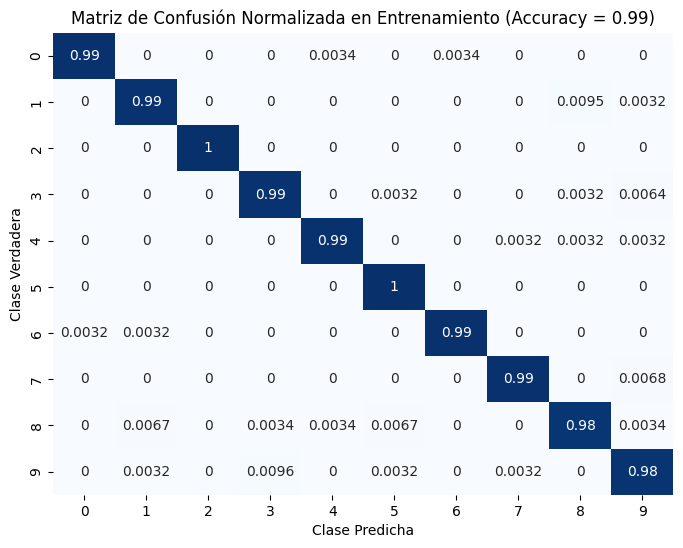

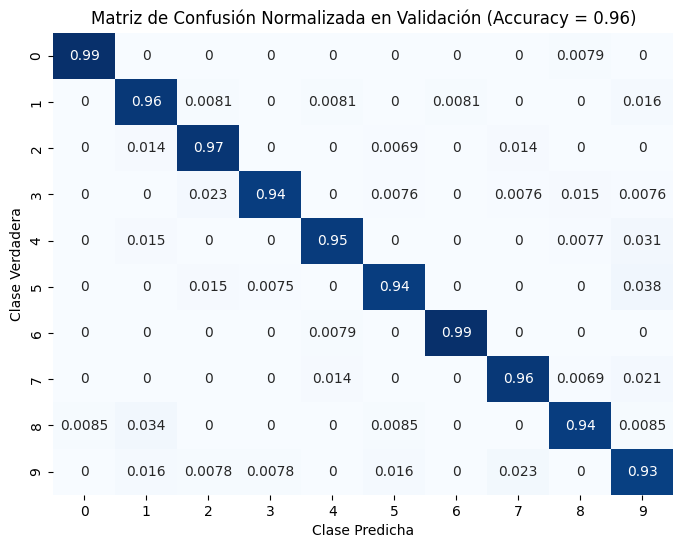

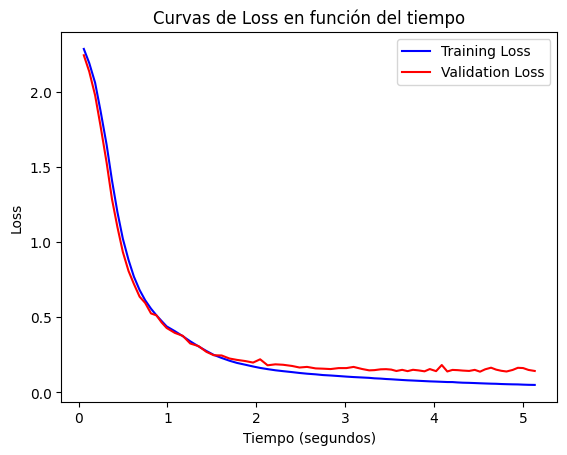

In [15]:
#Modelo 5
#2 capas ocultas con 10 y 10 neuronas cada una y función de activación ReLU
model5 = nn.Sequential(
          nn.Linear(64,10), #Capa de entrada con 64 caracteristicas y 10 neuronas
          nn.ReLU(),        #Función de activación ReLU
          nn.Linear(10,10), #Segunda capa oculta con 10 neuronas
          nn.ReLU(),        #Función de activación ReLU
          nn.Linear(10,10)  #Capa de salida 10 neuronas
        )

#Funciones de los modelos
device = torch.device('cuda')
model5 = model5.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model5.parameters(), lr=1e-3)

#Entrenar
trainning(model5)

Epoch: 0, train loss: 2.1947, val loss: 2.0658
Epoch: 1, train loss: 1.8402, val loss: 1.5941
Epoch: 2, train loss: 1.2901, val loss: 0.9975
Epoch: 3, train loss: 0.7486, val loss: 0.5589
Epoch: 4, train loss: 0.4388, val loss: 0.3541
Epoch: 5, train loss: 0.2913, val loss: 0.2403
Epoch: 6, train loss: 0.2199, val loss: 0.1958
Epoch: 7, train loss: 0.1766, val loss: 0.1576
Epoch: 8, train loss: 0.1491, val loss: 0.1512
Epoch: 9, train loss: 0.1284, val loss: 0.1247
Epoch: 10, train loss: 0.1137, val loss: 0.1269
Epoch: 11, train loss: 0.1011, val loss: 0.1123
Epoch: 12, train loss: 0.0903, val loss: 0.1073
Epoch: 13, train loss: 0.0813, val loss: 0.0940
Epoch: 14, train loss: 0.0750, val loss: 0.1024
Epoch: 15, train loss: 0.0673, val loss: 0.0938
Epoch: 16, train loss: 0.0608, val loss: 0.0922
Epoch: 17, train loss: 0.0559, val loss: 0.0862
Epoch: 18, train loss: 0.0515, val loss: 0.0852
Epoch: 19, train loss: 0.0470, val loss: 0.0810
Epoch: 20, train loss: 0.0435, val loss: 0.0856
Ep

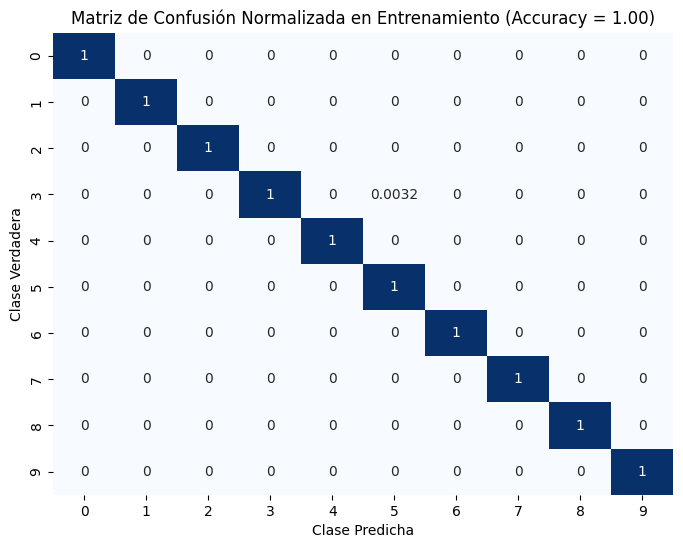

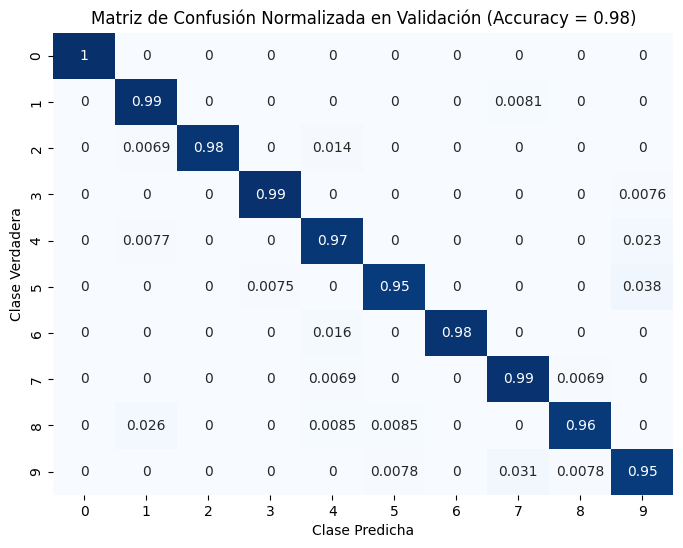

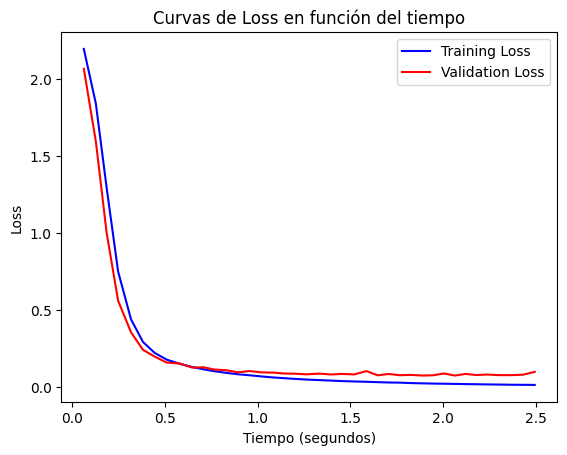

In [16]:
#Modelo 6
#2 capas ocultas con 40 y 40 neuronas cada una y función de activación ReLU
model6 = nn.Sequential(
          nn.Linear(64,40), #Capa de entrada con 64 caracteristicas y 40 neuronas
          nn.ReLU(),        #Función de activación ReLU
          nn.Linear(40,40), #Segunda capa oculta con 40 neuronas
          nn.ReLU(),        #Función de activación ReLU
          nn.Linear(40,10)  #Capa de salida 40 neuronas
        )

#Funciones de los modelos
device = torch.device('cuda')
model6 = model6.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model6.parameters(), lr=1e-3)

#Entrenar
trainning(model6)

###P3) Usando la mejor red encontrada en validación (aquella con mayor accuracy en validación), calcular la matriz de confusión normalizada y el accuracy normalizado, usando el conjunto de prueba.


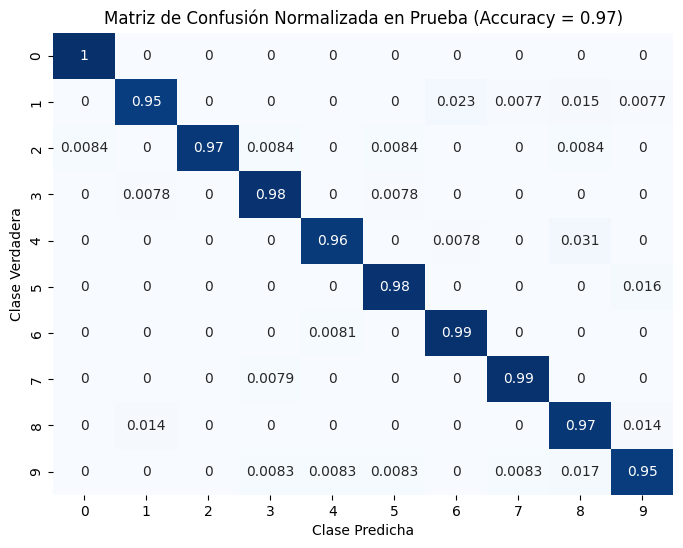

In [17]:
#Modelo 4
#40 neuronas en la capa oculta y función de activación Tanh
with torch.no_grad():
    test_labels = []
    test_predictions = []

    for i, data in enumerate(dataloader_test, 0):
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)

        outputs = model4(inputs)
        _, predicted = torch.max(outputs, 1)

        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(predicted.cpu().numpy())

# Calcular la matriz de confusión en el conjunto de prueba
confusion_matrix_normalized_test = confusion_matrix(test_labels, test_predictions, normalize='true')

# Calcular el accuracy normalizado en el conjunto de prueba
accuracy_normalized_test = accuracy_score(test_labels, test_predictions)

# Mostrar la matriz de confusión en el conjunto de prueba con colores
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_normalized_test, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title(f'Matriz de Confusión Normalizada en Prueba (Accuracy = {accuracy_normalized_test:.2f})')
plt.show()